CIFAR100-Classification3

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable

In [3]:
#设置基本参数
batch_size = 64
learning_rate = 0.01
#learning_rate = 0.02
num_epochs = 16

In [4]:
#数据标准化
data_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]),
    'test':
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]),
}

保持网络畅通，这个下载挺快的

In [16]:
#在线下载数据
data_sets = {
    'train': torchvision.datasets.CIFAR100(root='data', train=True, download=True, transform=data_transforms['train']),
    'test': torchvision.datasets.CIFAR100(root='data', download=True, transform=data_transforms['test'])
}
#查看数据信息
print(data_sets['train'])

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )


In [17]:
#加载数据到torch中，训练集使用shuffle
dataloaders = {
    'train':
    torch.utils.data.DataLoader(data_sets['train'],
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0),
    'test':
    torch.utils.data.DataLoader(data_sets['test'],
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=0)
}

In [18]:
#检查GPU是否可用
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cpu


In [19]:
#准备网络模型，使用的是resnet50，可以在线下载模型
model = models.resnet50(pretrained=True)

model = model.cuda() if use_cuda else model
    
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1024)
model.fc = nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(num_ftrs, 1024),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(1024, 512),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(512, 256),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 128),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, len(data_sets['train'].classes))
)

model.fc = model.fc.cuda() if use_cuda else model.fc

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [20]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
#数据训练和检测
train_acces, test_acces = [], []
train_losses, test_losses = [], []
total_step = len(dataloaders['train'])
test_loss_min = np.Inf
for epoch in range(num_epochs):
    print(f'Epoch {epoch}\n')

    network_learned = False

    for phase in ['train', 'test']:

        running_loss = 0.0
        running_corrects = 0

        if phase == 'train':
            model.train()

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):

                if use_cuda:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
  
                inputs = inputs.float()
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                if (batch_idx) % 20 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs-1, batch_idx, total_step, loss.item()))
            scheduler.step()
        else:
            with torch.no_grad():
                model.eval()
                for inputs, labels in dataloaders[phase]:
                    if use_cuda:
                        inputs = Variable(inputs.cuda())
                        labels = Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                    
                    inputs = inputs.float()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels.data)
            network_learned = running_loss < test_loss_min
            test_loss_min = running_loss if network_learned else test_loss_min


        epoch_loss = running_loss / len(data_sets[phase])
        epoch_acc = running_corrects.double() / len(data_sets[phase])
        
        if phase == 'train':
            train_acces.append(epoch_acc * 100)
            train_losses.append(epoch_loss)
        else:
            test_acces.append(epoch_acc * 100)
            test_losses.append(epoch_loss)
    print(f'\ntrain-loss: {np.mean(train_losses):.4f}, train-acc: {train_acces[-1]:.4f}')
    print(f'test loss: {np.mean(test_losses):.4f}, test acc: {test_acces[-1]:.4f}\n')

    if network_learned:
        torch.save(model.state_dict(), './models/weights.h5')
        print('Improvement-Detected, save-model')

Epoch 0

Epoch [0/15], Step [0/782], Loss: 4.6158
Epoch [0/15], Step [20/782], Loss: 4.6153
Epoch [0/15], Step [40/782], Loss: 4.6248
Epoch [0/15], Step [60/782], Loss: 4.5515
Epoch [0/15], Step [80/782], Loss: 4.3367
Epoch [0/15], Step [100/782], Loss: 4.0509
Epoch [0/15], Step [120/782], Loss: 4.0236
Epoch [0/15], Step [140/782], Loss: 3.8641
Epoch [0/15], Step [160/782], Loss: 3.7379
Epoch [0/15], Step [180/782], Loss: 3.1923
Epoch [0/15], Step [200/782], Loss: 3.2778
Epoch [0/15], Step [220/782], Loss: 3.1392
Epoch [0/15], Step [240/782], Loss: 3.3162
Epoch [0/15], Step [260/782], Loss: 3.3497
Epoch [0/15], Step [280/782], Loss: 2.9117
Epoch [0/15], Step [300/782], Loss: 3.3305
Epoch [0/15], Step [320/782], Loss: 3.2646
Epoch [0/15], Step [340/782], Loss: 3.0170
Epoch [0/15], Step [360/782], Loss: 2.7164
Epoch [0/15], Step [380/782], Loss: 2.7460
Epoch [0/15], Step [400/782], Loss: 3.2040
Epoch [0/15], Step [420/782], Loss: 2.8882
Epoch [0/15], Step [440/782], Loss: 2.8224
Epoch [0

Epoch [4/15], Step [400/782], Loss: 1.8012
Epoch [4/15], Step [420/782], Loss: 2.1234
Epoch [4/15], Step [440/782], Loss: 2.0976
Epoch [4/15], Step [460/782], Loss: 1.9962
Epoch [4/15], Step [480/782], Loss: 2.1120
Epoch [4/15], Step [500/782], Loss: 1.7949
Epoch [4/15], Step [520/782], Loss: 1.9850
Epoch [4/15], Step [540/782], Loss: 1.7502
Epoch [4/15], Step [560/782], Loss: 2.1557
Epoch [4/15], Step [580/782], Loss: 1.9549
Epoch [4/15], Step [600/782], Loss: 1.7579
Epoch [4/15], Step [620/782], Loss: 1.9120
Epoch [4/15], Step [640/782], Loss: 1.7786
Epoch [4/15], Step [660/782], Loss: 2.0907
Epoch [4/15], Step [680/782], Loss: 2.2200
Epoch [4/15], Step [700/782], Loss: 2.1458
Epoch [4/15], Step [720/782], Loss: 2.1529
Epoch [4/15], Step [740/782], Loss: 1.4499
Epoch [4/15], Step [760/782], Loss: 1.6431
Epoch [4/15], Step [780/782], Loss: 1.8070

train-loss: 0.0360, train-acc: 50.9220
test loss: 0.0291, test acc: 58.9320

Improvement-Detected, save-model
Epoch 5

Epoch [5/15], Step [


train-loss: 0.0310, train-acc: 59.8340
test loss: 0.0251, test acc: 66.3020

Improvement-Detected, save-model
Epoch 9

Epoch [9/15], Step [0/782], Loss: 1.2459
Epoch [9/15], Step [20/782], Loss: 1.3318
Epoch [9/15], Step [40/782], Loss: 1.1353
Epoch [9/15], Step [60/782], Loss: 1.2067
Epoch [9/15], Step [80/782], Loss: 1.0678
Epoch [9/15], Step [100/782], Loss: 2.0701
Epoch [9/15], Step [120/782], Loss: 1.3758
Epoch [9/15], Step [140/782], Loss: 1.3212
Epoch [9/15], Step [160/782], Loss: 1.4553
Epoch [9/15], Step [180/782], Loss: 1.1758
Epoch [9/15], Step [200/782], Loss: 1.4728
Epoch [9/15], Step [220/782], Loss: 1.0573
Epoch [9/15], Step [240/782], Loss: 1.5021
Epoch [9/15], Step [260/782], Loss: 1.5964
Epoch [9/15], Step [280/782], Loss: 1.1568
Epoch [9/15], Step [300/782], Loss: 1.6284
Epoch [9/15], Step [320/782], Loss: 1.6117
Epoch [9/15], Step [340/782], Loss: 0.9425
Epoch [9/15], Step [360/782], Loss: 1.5611
Epoch [9/15], Step [380/782], Loss: 1.4316
Epoch [9/15], Step [400/78

Epoch [13/15], Step [300/782], Loss: 0.5018
Epoch [13/15], Step [320/782], Loss: 0.3535
Epoch [13/15], Step [340/782], Loss: 0.7694
Epoch [13/15], Step [360/782], Loss: 0.4586
Epoch [13/15], Step [380/782], Loss: 0.4926
Epoch [13/15], Step [400/782], Loss: 0.5330
Epoch [13/15], Step [420/782], Loss: 0.6189
Epoch [13/15], Step [440/782], Loss: 0.3369
Epoch [13/15], Step [460/782], Loss: 0.4647
Epoch [13/15], Step [480/782], Loss: 0.6629
Epoch [13/15], Step [500/782], Loss: 0.5346
Epoch [13/15], Step [520/782], Loss: 0.7827
Epoch [13/15], Step [540/782], Loss: 0.7456
Epoch [13/15], Step [560/782], Loss: 1.0851
Epoch [13/15], Step [580/782], Loss: 0.5747
Epoch [13/15], Step [600/782], Loss: 0.4851
Epoch [13/15], Step [620/782], Loss: 0.6487
Epoch [13/15], Step [640/782], Loss: 0.4614
Epoch [13/15], Step [660/782], Loss: 0.6393
Epoch [13/15], Step [680/782], Loss: 0.5869
Epoch [13/15], Step [700/782], Loss: 0.4120
Epoch [13/15], Step [720/782], Loss: 0.4149
Epoch [13/15], Step [740/782], L

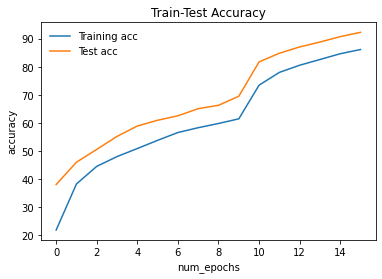

In [28]:
plt.title("Train-Test Accuracy")
plt.plot(train_acces, label='Training acc')
plt.plot(test_acces, label='Test acc')
plt.xlabel('num_epochs')
plt.ylabel('accuracy')
plt.legend(frameon=False)
plt.show()

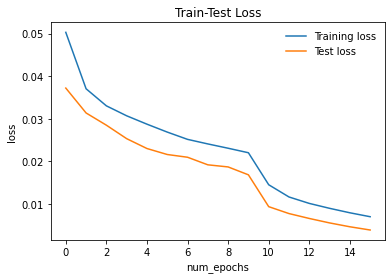

In [29]:
plt.title("Train-Test Loss")
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('num_epochs')
plt.ylabel('loss')
plt.legend(frameon=False)
plt.show()